## libraries import and data loading

if you want you can run this notebook in google colaboratory platfotm using [this link](https://colab.research.google.com/github/paq88/Neural_network_classifier/blob/main/Fish_model_NN_gut.ipynb)


In [91]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# Function for plotting probability for each class
def plot_prob(y_pred):
    prob_value = list(map(max, y_pred))
    y_pred_class = y_pred.argmax(axis=1)

    predict_df = pd.DataFrame({"pred_class":y_pred_class,"prob_value":prob_value})
    for clas in predict_df["pred_class"].unique():
        plt.scatter(y=predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], 
            x=[clas] * len(predict_df.loc[predict_df["pred_class"] == clas]),marker = ".",label = clas)
        plt.title("Probability of predicted class")
        plt.ylabel("Probability")
        plt.xlabel("Classes")
    plt.legend(loc='upper left')
plot_prob(y_pred)

In [92]:
# function for plot evaluation
def evaluate_model(model, history, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = y_pred.argmax(axis=1)
    y_test_class = y_test.argmax(axis=1)
    print(y_pred_class)
    print(y_test_class)
    # Assuming plot_prob is defined elsewhere
    plot_prob(y_pred)

    sample_weight = (y_pred_class != y_test_class)
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_pred_class, y_test_class, #sample_weight=sample_weight,
                                             normalize="true", values_format=".0%")

    # Plot training and validation loss
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"], 'r', marker='.', label="Train Loss")
    ax.plot(history.history["val_loss"], 'b', marker='.', label="Validation loss")
    ax.legend()
    ax.set_title("DNN_Gut_loss")

    # Plot training and validation accuracy
    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"], 'r', marker='.', label="Train accuracy")
    ax.plot(history.history["val_accuracy"], 'b', marker='.', label="Validation accuracy")
    ax.legend()
    ax.set_title("DNN_Gut_acc")


In [2]:
# load data from github 

df = pd.read_csv('https://raw.githubusercontent.com/paq88/Neural_network_classifier/main/data/gut_full_feature_table.csv')
print(df.shape)
print(df.dtypes)
df.head()

(124, 127)
pond                                                                                           object
d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae             float64
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae       float64
d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae                    float64
d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae                    float64
                                                                                               ...   
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae           float64
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae      float64
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae           float64
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After ininitial inspection of data we have a lot of missing values, in case of our data missing value means zero abduance of bacteria was found by upstream analysys so we can safely replace those with zeros

In [3]:
df = df.fillna(0)
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,831.653226,8693.169355,171.370968,71.137097,105.548387,196.209677,677.419355,375.854839,53.169355,25.241935,...,0.096774,0.298387,0.080645,2.153226,0.217742,1.604839,0.153226,0.096774,0.266129,0.185484
std,1120.105607,5604.123141,224.484829,146.755443,192.490201,637.902078,2845.964849,456.780652,98.483354,67.552253,...,1.077632,2.270274,0.898027,20.938565,2.093585,13.805159,1.706250,1.077632,2.537872,2.065461
min,0.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.750000,3913.500000,37.750000,0.000000,0.000000,6.750000,0.000000,55.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,469.500000,7454.500000,105.500000,2.000000,13.500000,27.500000,0.000000,211.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1037.750000,12774.000000,241.000000,91.500000,131.000000,118.250000,48.750000,467.250000,62.250000,15.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6597.000000,26160.000000,1743.000000,1054.000000,1024.000000,5020.000000,23193.000000,2505.000000,581.000000,539.000000,...,12.000000,23.000000,10.000000,232.000000,23.000000,144.000000,19.000000,12.000000,28.000000,23.000000


After seeing some basic statistics regarding columns we can see that range of valueus varries a lot we should normalise collumns (features).
We should also perform conversion of class variable to assign samples from different ponds to class used later for training of the model.

## conversion of class variable


Explanation of pond coding
| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [5]:
#creting decoder for 5 classes (original experimental setups)
# codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   
#pond_decoder("gut_14")

In [6]:
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# creaton of datasets for different class numbers we can do that as our dataset is not nearly big enough for that to be a problem
df_5 = df.copy()
df_3 = df.copy()
df_2 = df.copy()

In [8]:
# creating dataset splitted into 5 classes 

#performing change of target variable collumn 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df_5['pond'] = df_5['pond'].apply(lambda x: pond_decoder(x,codes))


In [9]:
#converting into category variable 
df_5['pond'] = df_5['pond'].astype('category')

In [10]:
#checking category variable 
df_5.head()
df_5.describe()
df_5['pond'].unique()

[2, 4, 1, 3, 0]
Categories (5, int64): [0, 1, 2, 3, 4]

## target and predictor variables set creation and normalization 
we will normalize predictor variables we will normalise by dividing each value in column by maximum value of that columna. We want to get rid of variance between features. This approach gave better results than normalising by samples (rows) but it is worth to check that as well if desired. We will also convert labels to one hot encoding.

In [11]:
target = ['pond']
predictors = list(set(list(df_5.columns)) - set(target))
#print(predictors)

In [12]:
#normalisation by collumns best for now 
df_5[predictors]=df_5[predictors]/df_5[predictors].max()

#normalisation by rows 
#df_5[predictors] = df_5[predictors].apply(lambda row: row / row.max(axis=0), axis=0)

#normalisation using sklearn 
#df_5[predictors] = normalize(df_5[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [13]:
#replacing 0 values with small value if desired.

#df_5[predictors] = df_5[predictors].replace(0,0.00001)


In [14]:
df_5.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,0.046831,...,0.008065,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065
std,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,0.125329,...,0.089803,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803
min,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,0.028293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Here we can see results of normalisation as each feature is getting values in the same range (0:1) this proved to help model to learn better.

## Splitting data into train and test sets


In [15]:
X=df_5[predictors].values
y=df_5[target].values
yt = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(86, 126) (38, 126) (86, 5) (38, 5)


At this point we have data ready for modeling with test size 30% of data, having 126 columns of bacteria abduance as predictor variables 86 reads as train set) and experimental setup as target varaible ( 1 column) with 5 classes we made sure that there is good representation of classes in each of datasets, we will use test dataset for validation during training as we dont have enought data and validation set does not impact model learning (mostly).

# Model building, compiling, fitting

My initial strategy as we have not much data is to have some more dropout to prevent overfitting and lower learning rate as well as more epochs to compensate for dropout.
- For loss function we will use [caterogical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as we have several encoded categories
- For metrics we will use [accuracy](https://keras.io/api/metrics/accuracy_metrics/) as it works well with our integer mutliclass predictor variable
- For optimizer we will chose Adam as it is an usual choice [optimzier choosing](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e) we will set small learning rate at beggining but it might be that our network will rapidly stop learning becouse of that, in that case it is neccesary to update learning rate to bigger number

## model building and compiling
the following model is result of many trial and error atemppts to create best classifier.  
 model with 2 hidedn layers with relu as an activation function. we have no values below zero/one so relu is predicting practically lineary but it is giving best results as sigmoid is too agresive and loss function is varring by a lot during training ("jumping"), also two dropout layers to prevent overfitting and one output layer with softmax activation function.

In [16]:
model1 = keras.Sequential()
# strasznie duży model nie działa jak coś xd


model1.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(5, activation ='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16256     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 25637 (100.14 KB)
Trainable params: 25637 

In [17]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = "accuracy"

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [18]:

history1=model1.fit(X_train, y_train, epochs = 750, verbose = 1, shuffle = True, validation_data=(X_test, y_test))


Epoch 1/750
3/3 [==============================] - 3s 260ms/step - loss: 1.6158 - accuracy: 0.2674 - val_loss: 1.5959 - val_accuracy: 0.2632
Epoch 2/750
3/3 [==============================] - 0s 41ms/step - loss: 1.6144 - accuracy: 0.2326 - val_loss: 1.5955 - val_accuracy: 0.2632
Epoch 3/750
3/3 [==============================] - 0s 39ms/step - loss: 1.6081 - accuracy: 0.2326 - val_loss: 1.5951 - val_accuracy: 0.2632
Epoch 4/750
3/3 [==============================] - 0s 43ms/step - loss: 1.5939 - accuracy: 0.2791 - val_loss: 1.5947 - val_accuracy: 0.2632
Epoch 5/750
3/3 [==============================] - 0s 40ms/step - loss: 1.6072 - accuracy: 0.2209 - val_loss: 1.5943 - val_accuracy: 0.2895
Epoch 6/750
3/3 [==============================] - 0s 41ms/step - loss: 1.6008 - accuracy: 0.2209 - val_loss: 1.5938 - val_accuracy: 0.2895
Epoch 7/750
3/3 [==============================] - 0s 40ms/step - loss: 1.6033 - accuracy: 0.2442 - val_loss: 1.5934 - val_accuracy: 0.2895
Epoch 8/750
3/3 [==

# model evaluation
After training our data its time to evaluate model
we will start by extracting predicted classes from our predictions

2/2 [==============================] - 0s 2ms/step
[4 3 2 3 2 4 4 2 2 3 2 3 4 4 1 3 4 3 3 4 1 2 1 1 4 0 0 3 0 1 1 4 4 4 4 2 0
 2]
[4 0 2 3 2 0 4 2 4 3 2 3 1 2 0 3 0 4 1 4 0 4 3 1 4 0 1 1 0 3 1 4 1 2 1 2 3
 2]


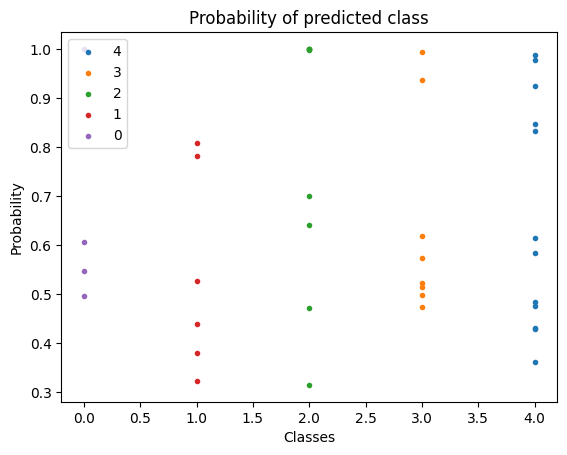

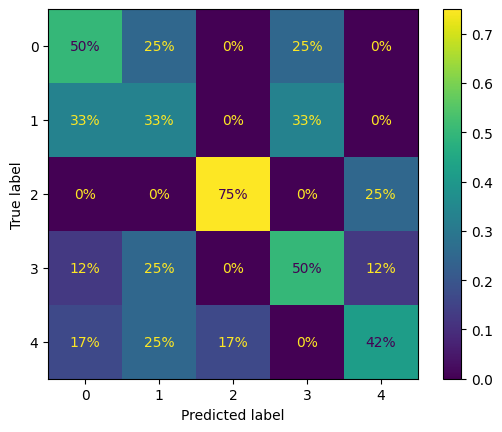

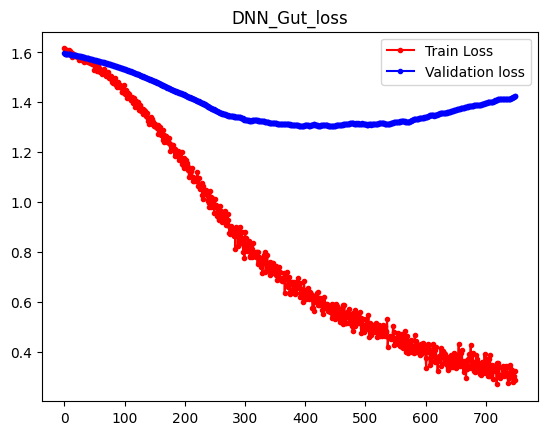

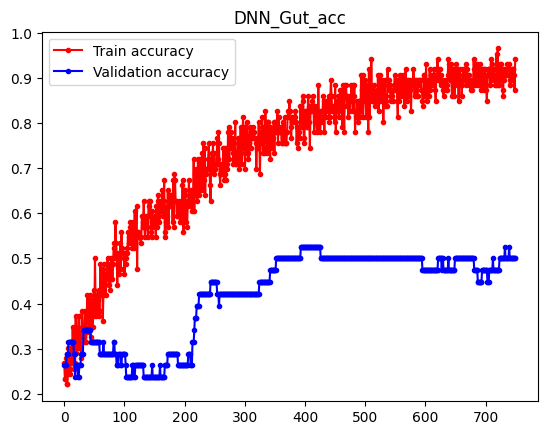

In [93]:
evaluate_model(model1, history1, X_test, y_test)

In [19]:
y_pred = model1.predict(X_test)

print(y_pred[:1])
# we need to convert those to classes 
y_pred_class = y_pred.argmax(axis=1)
print(y_pred_class[1])

2/2 [==============================] - 0s 5ms/step
[[0.04161862 0.07447665 0.02199691 0.02875918 0.83314854]]
3


In [20]:
# just to check how the output looks like we have to also convert our original test values
print("predicted classes: ",y_pred_class[:3])
print(y_test[:3])
y_test_classes = y_test.argmax(axis=1)
print("True classes: ",y_test_classes[:3])

predicted classes:  [4 3 2]
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
True classes:  [4 0 2]


In [21]:
# here its just evaluation on train and test set (same as if we looked at end of history of training)
print(model1.evaluate(X_train,y_train))
print(model1.evaluate(X_test,y_test))

3/3 [==============================] - 0s 6ms/step - loss: 0.2475 - accuracy: 0.9535
[0.24752706289291382, 0.9534883499145508]
2/2 [==============================] - 0s 11ms/step - loss: 1.4250 - accuracy: 0.5000
[1.4249731302261353, 0.5]


## Accuraacy and Loss function plots

In [22]:
history1.history.keys() 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

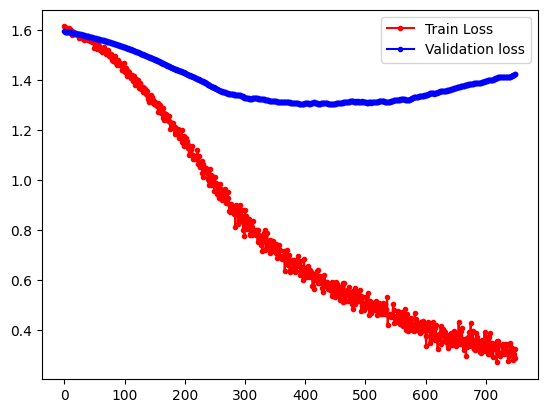

In [23]:
title = "DNN_Gut_loss"
fig, ax = plt.subplots()
ax.plot(history1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history1.history["val_loss"],'b', marker='.', label="Validation loss")
ax.legend()
#plt.savefig(title+'.png')

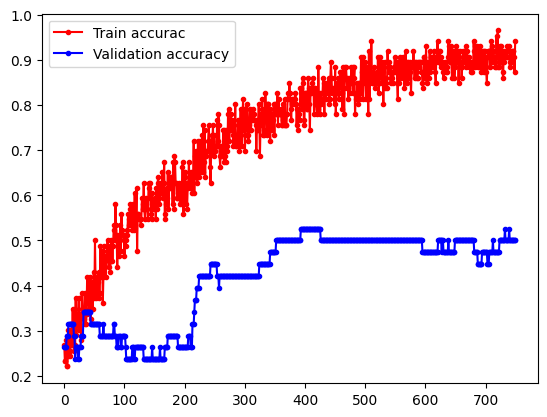

In [24]:
fig, ax = plt.subplots()
title = "DNN_Gut_acc"
ax.plot(history1.history["accuracy"],'r', marker='.', label="Train accurac")
ax.plot(history1.history["val_accuracy"],'b', marker='.', label="Validation accuracy")
ax.legend()
#plt.savefig(title+'.png')

On this plots we can see that model reached peak accuracy for validation dataset of around 0.6 after around 280 epochs and then accuracy started to drop, similar conclusions we can draw from loss function plot where we can see overfitting to data near 350 epochs. 

## Probability ploting
We also want to see how sure model is of its predictions so we will plot highest probabity of belonging to classes

We can see here that model is not "sure" of its decisions in most of the cases. 

## Confusion matrix
We created confusion matrix to acces quality of the model and its predictions we can easily see using this tool what classes are most difficult to recognize by the model

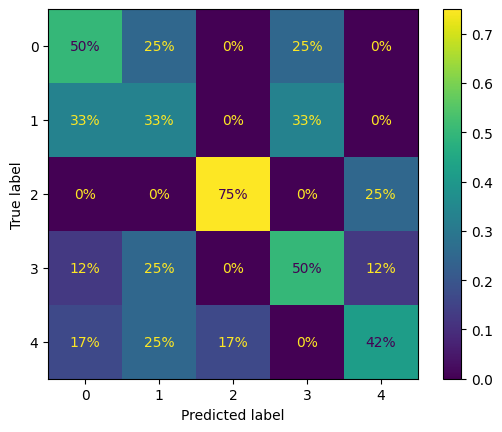

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_class = y_test.argmax(axis = 1)
sample_weight=(y_pred_class != y_test_class )
plt.rc('font',size = 10)
ConfusionMatrixDisplay.from_predictions(y_pred_class,y_test_class, #sample_weight = sample_weight,
                                        normalize = "true", values_format = ".0%")


Explanation of pond coding
| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

So as we can see model is confusing setup 1 with 3, 0 and vice versa, similar case to 2 and 4. the reason for this is feed suplementation similarities between those setups. We could draw conclusions that feed supplementation has much more impact on microbiome than water supplementation.  With this knowledge we will divide data into  categories and see if results improve.

# 3 classes
Here we will divide dataset into 3 classes 
0 - control (no water or feed suplementation)
1 - no feed suplementation 
2 - feed suplementation

In [27]:
#creting decoder we will change our decoder to divide into 3 classes

def pond_decoder(x,codes):
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   
    
#pond_decoder("gut_14")

In [28]:
#performing change of target variable collumn 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26,9,13,17,20,27], 2 : [10,21,28,30,32,11,15,22,25,31]}


df_3['pond'] = df_3['pond'].apply(lambda x: pond_decoder(x,codes))


In [29]:
df_3['pond'] = df_3['pond'].astype('category')

In [30]:
df_3.head()
df_3.describe()
df_3['pond'].unique()

[2, 1, 0]
Categories (3, int64): [0, 1, 2]

## target and predictor variables set creation and normalization 
we will normalize predictor variables we will normalise by dividing each value in row by maximum value of that row. We want to get rid of variance between samples thats why we normalise by rows not by collumns. We will also convert labels to one hot encoding ones.

In [31]:
target = ['pond']
predictors = list(set(list(df_3.columns)) - set(target))
#print(predictors)

In [32]:
#normalisation by collumns best for now 
df_3[predictors]=df_3[predictors]/df_3[predictors].max()

#normalisation by rows 
#df_3[predictors] = df_3[predictors].apply(lambda row: row / row.max(axis=0), axis=0)

#normalisation using sklearn 
#df_3[predictors] = normalize(df_3[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [33]:
#replacing 0 values with small value 
#df_3[predictors] = df_3[predictors].replace(0,0.00001)


In [34]:
df_3.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,0.046831,...,0.008065,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065
std,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,0.125329,...,0.089803,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803
min,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,0.028293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting data into train and test sets


In [35]:
X3=df_3[predictors].values
y3=df_3[target].values
yt3 = keras.utils.to_categorical(y3, 3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,yt3,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(86, 126) (38, 126) (86, 5) (38, 5)


At this point we have data ready for modeling with test size 30% of data, having 126 columns of bacteria abduance as predictor variables 86 reads as train set) and experimental setup as target varaible ( 1 column) with 3 classes we made sure that there is good representation of classes in each of datasets, we will use test dataset for validation during training as we dont have enought data and validation set does not 

## Model building, compiling, fitting

## model building and compiling


In [36]:
model3 = keras.Sequential()


model3.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               16256     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 25603 (100.01 KB)
Trainable params: 2560

In [37]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [38]:

history3=model3.fit(X_train3, y_train3, epochs = 750, verbose = 1, shuffle = True, validation_data=(X_test3, y_test3))


Epoch 1/750
3/3 [==============================] - 3s 347ms/step - loss: 1.1041 - accuracy: 0.2093 - val_loss: 1.0950 - val_accuracy: 0.2895
Epoch 2/750
3/3 [==============================] - 0s 47ms/step - loss: 1.0875 - accuracy: 0.4535 - val_loss: 1.0938 - val_accuracy: 0.3158
Epoch 3/750
3/3 [==============================] - 0s 48ms/step - loss: 1.0912 - accuracy: 0.3721 - val_loss: 1.0929 - val_accuracy: 0.3421
Epoch 4/750
3/3 [==============================] - 0s 44ms/step - loss: 1.0907 - accuracy: 0.4302 - val_loss: 1.0918 - val_accuracy: 0.3684
Epoch 5/750
3/3 [==============================] - 0s 41ms/step - loss: 1.1014 - accuracy: 0.3372 - val_loss: 1.0908 - val_accuracy: 0.3684
Epoch 6/750
3/3 [==============================] - 0s 41ms/step - loss: 1.0990 - accuracy: 0.3721 - val_loss: 1.0899 - val_accuracy: 0.3684
Epoch 7/750
3/3 [==============================] - 0s 42ms/step - loss: 1.0843 - accuracy: 0.4186 - val_loss: 1.0889 - val_accuracy: 0.3947
Epoch 8/750
3/3 [==

## model evaluation

2/2 [==============================] - 0s 4ms/step
[2 0 2 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 1 2 2 2 1 1 2 0 1 1 1 1 0 1 1 2 2 2 1
 2]
[2 0 2 1 2 0 2 2 2 1 2 1 1 2 0 1 0 2 1 2 0 2 1 1 2 0 1 1 0 1 1 2 1 2 1 2 1
 2]


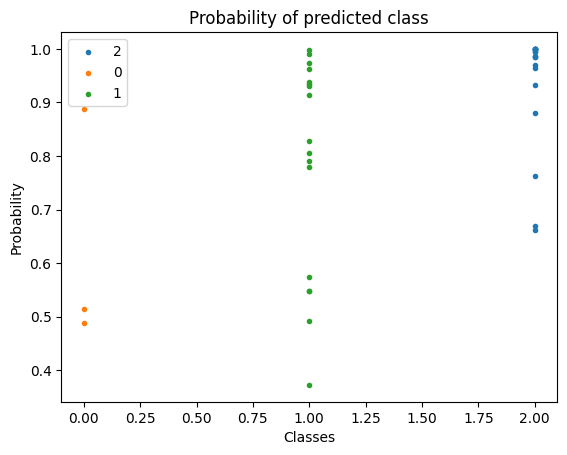

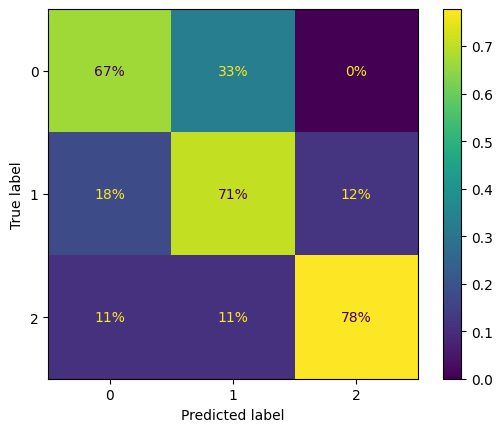

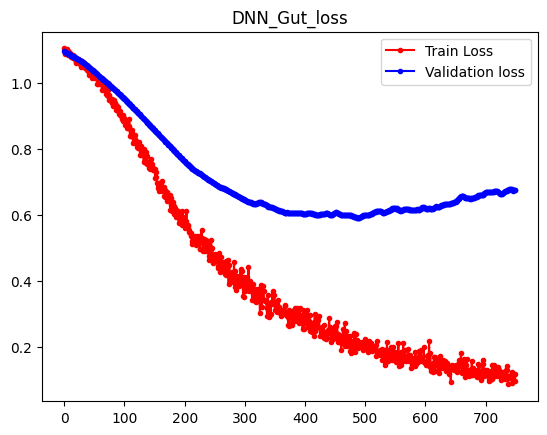

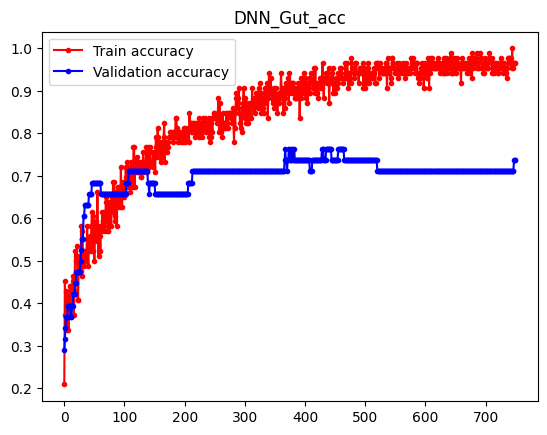

In [97]:
evaluate_model(history = history3, model = model3, X_test = X_test3, y_test = y_test3)

Here we will plot probablity belonging some class for each sample to see how "sure" model is of its decisions.

To remind ourselves what classes look like 
| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|control(0) | 8,14,18,24,29|NO|
|1|1|12,16,19,23,26,9,13,17,20,27|NO|
|2|2| 10,21,28,30,32,11,15,22,25,31|EM|


As we can see this did help a bit, accuracy rised to around 0.7 (70% of predictions were matches). Looking at confusion matrix the results for 1 and 2 class are good problem is with controll class, although it is understandable why model is confusing control with 1 class based on conclusions we draw before that feed suplementation has much more impact it is weird that model is misstaking 0 class as 2 class. We might try binary classification approach based only on feed suplementation without control group. 

# 2 classes
As we mentioned later here we will focus only on 2 classes 
- 0 - no feed classification 
- 1 - feed suplementation 

In [47]:
#performing change of target variable collumn 
codes = {0 : [8,14,18,24,29,12,16,19,23,26,9,13,17,20,27], 1 : [10,21,28,30,32,11,15,22,25,31]}

df_2['pond'] = df_2['pond'].apply(lambda x: pond_decoder(x,codes))


In [48]:
df_2['pond'] = df_2['pond'].astype('category')

In [49]:
df_2.head()
df_2.describe()
df_2['pond'].unique()

[1, 0]
Categories (2, int64): [0, 1]

## target and predictor variables set creation and normalization 
we will normalize predictor variables we will normalise by dividing each value in row by maximum value of that row. We want to get rid of variance between samples thats why we normalise by rows not by collumns. We will also convert labels to one hot encoding ones.

In [50]:
target = ['pond']
predictors = list(set(list(df_2.columns)) - set(target))
#print(predictors)

In [51]:
#normalisation by collumns best for now 
df_2[predictors]=df_2[predictors]/df_2[predictors].max()

#normalisation by rows 
#df_2[predictors] = df_2[predictors].apply(lambda row: row / row.max(axis=0), axis=0)

#normalisation using sklearn 
#df_2[predictors] = normalize(df_2[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [52]:
#replacing 0 values with small value 
#df_2[predictors] = df_2[predictors].replace(0,0.00001)


In [53]:
df_2.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,0.046831,...,0.008065,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065
std,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,0.125329,...,0.089803,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803
min,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,0.028293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting data into train and test sets


In [54]:
X2=df_2[predictors].values
y2=df_2[target].values
yt2 = keras.utils.to_categorical(y2, 2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,yt2,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape)


(86, 126) (38, 126) (86, 2) (38, 2)


In [55]:
y_train2[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## model building and compiling

In [56]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               16256     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 25586 (99.95 KB)
Trainable params: 25586 (99.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [58]:

history2=model2.fit(X_train2, y_train2, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test2, y_test2))


Epoch 1/300
3/3 [==============================] - 2s 233ms/step - loss: 0.6995 - accuracy: 0.3837 - val_loss: 0.6935 - val_accuracy: 0.4737
Epoch 2/300
3/3 [==============================] - 0s 41ms/step - loss: 0.6976 - accuracy: 0.4070 - val_loss: 0.6929 - val_accuracy: 0.4737
Epoch 3/300
3/3 [==============================] - 0s 45ms/step - loss: 0.6959 - accuracy: 0.4535 - val_loss: 0.6923 - val_accuracy: 0.5263
Epoch 4/300
3/3 [==============================] - 0s 42ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.6316
Epoch 5/300
3/3 [==============================] - 0s 43ms/step - loss: 0.6927 - accuracy: 0.5465 - val_loss: 0.6912 - val_accuracy: 0.6053
Epoch 6/300
3/3 [==============================] - 0s 43ms/step - loss: 0.6913 - accuracy: 0.5698 - val_loss: 0.6907 - val_accuracy: 0.6316
Epoch 7/300
3/3 [==============================] - 0s 40ms/step - loss: 0.6900 - accuracy: 0.5930 - val_loss: 0.6902 - val_accuracy: 0.6842
Epoch 8/300
3/3 [==

## model evaluation

2/2 [==============================] - 0s 3ms/step
[1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 1]
[1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 1]


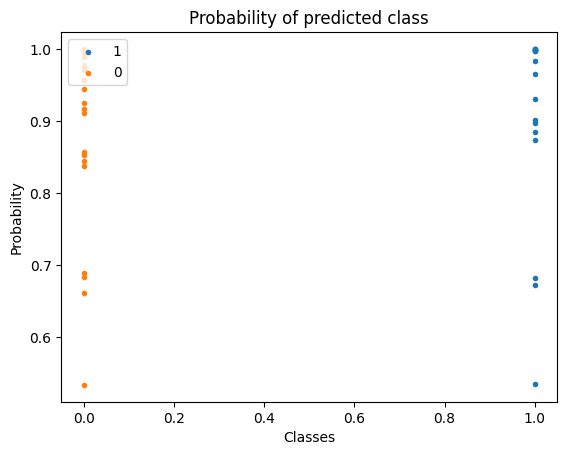

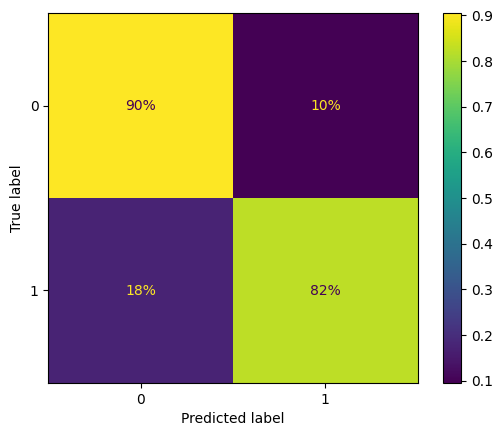

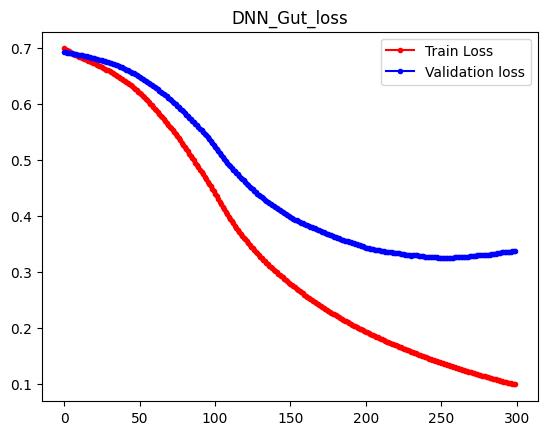

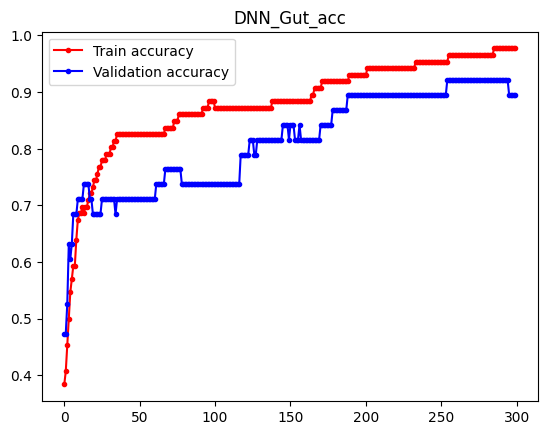

In [98]:
evaluate_model(history = history2, model = model2, X_test = X_test2, y_test = y_test2)

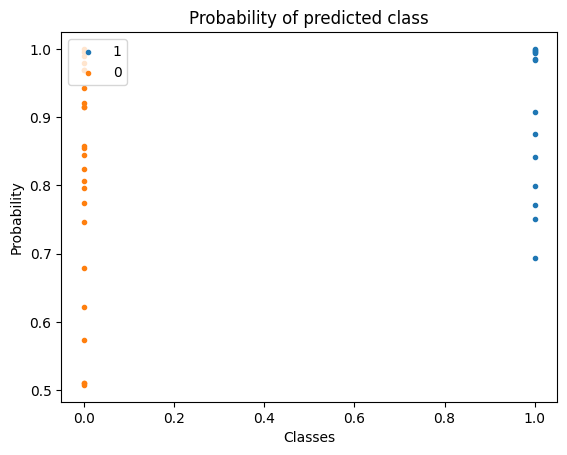

In [61]:
plot_prob(y_pred2)

To remind ourselves what the current classes look like 
| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|0|8,14,18,24,29,12,16,19,23,26,9,13,17,20,27|NO|
|1|1| 10,21,28,30,32,11,15,22,25,31|YES|

We can see much higher accuracy of the model -  0.9, overfitting is still a problem and it is starting even sooner at 300 epochs. But results are good 
Now as we know how the loss curve is looking like we will now try to implement early stopping callback so we can stop the model at the right point (in that peak 0.9 accuracy) as well as callback to save weights so we dont lose our progress

In [67]:
model2 = keras.Sequential()


model2.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               16256     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 2)                 34        
                                                                 
Total params: 25586 (99.95 KB)
Trainable params: 25586

In [68]:
model2 = keras.Sequential()


model2.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.1))
model2.add(keras.layers.Dense(32, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.16))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               16256     
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 20946 (81.82 KB)
Trainable params: 20946 (81.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
checkpoint_path = "NN_gut_2class/checkpoint"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(patience = 5)

In [70]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [90]:
# we create callback here to use tensorboard later on 
import os
logdir = os.path.join("tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history2_2=model2.fit(X_train2, y_train2, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test2, y_test2),callbacks = [tb_callback,cp_callback,es_callback])


Epoch 1/300
1/3 [=========>....................] - ETA: 0s - loss: 0.0961 - accuracy: 0.9375
Epoch 1: saving model to NN_gut_2class\checkpoint
3/3 [==============================] - 0s 138ms/step - loss: 0.0833 - accuracy: 0.9651 - val_loss: 0.3468 - val_accuracy: 0.8158
Epoch 2/300
1/3 [=========>....................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9688
Epoch 2: saving model to NN_gut_2class\checkpoint
3/3 [==============================] - 0s 82ms/step - loss: 0.0715 - accuracy: 0.9884 - val_loss: 0.3436 - val_accuracy: 0.8421
Epoch 3/300
1/3 [=========>....................] - ETA: 0s - loss: 0.0737 - accuracy: 1.0000
Epoch 3: saving model to NN_gut_2class\checkpoint
3/3 [==============================] - 0s 85ms/step - loss: 0.0869 - accuracy: 0.9767 - val_loss: 0.3390 - val_accuracy: 0.8947
Epoch 4/300
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - accuracy: 1.0000
Epoch 4: saving model to NN_gut_2class\checkpoint
3/3 [==============================] - 0s 9

We will also create function to evaluate models so we dont have to do that manually each time 

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, history, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = y_pred.argmax(axis=1)
    y_test_class = y_test.argmax(axis=1)
    print(y_pred_class)
    print(y_test_class)
    # Assuming plot_prob is defined elsewhere
    plot_prob(y_pred)

    sample_weight = (y_pred_class != y_test_class)
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_pred_class, y_test_class, #sample_weight=sample_weight,
                                             normalize="true", values_format=".0%")

    # Plot training and validation loss
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"], 'r', marker='.', label="Train Loss")
    ax.plot(history.history["val_loss"], 'b', marker='.', label="Validation loss")
    ax.legend()
    ax.set_title("DNN_Gut_loss")

    # Plot training and validation accuracy
    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"], 'r', marker='.', label="Train accuracy")
    ax.plot(history.history["val_accuracy"], 'b', marker='.', label="Validation accuracy")
    ax.legend()
    ax.set_title("DNN_Gut_acc")


2/2 [==============================] - 0s 3ms/step
[1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0
 1]
[1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 1]


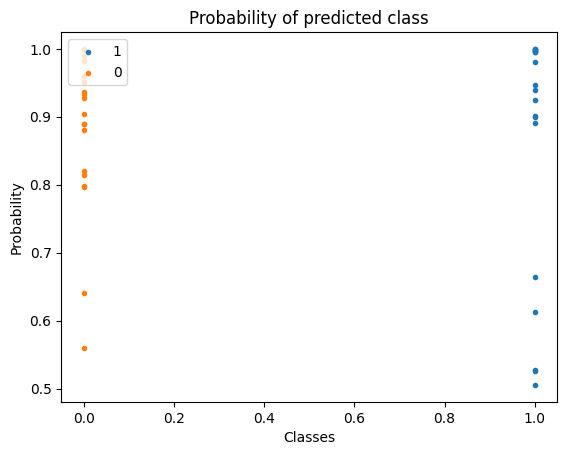

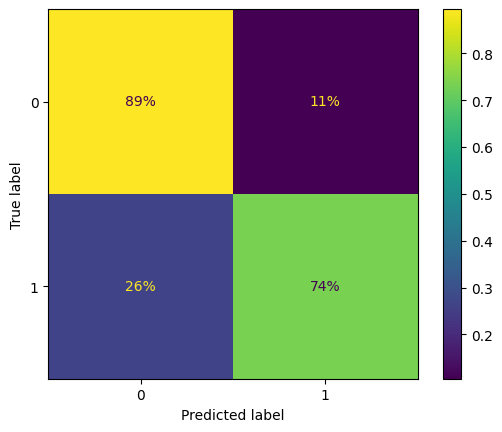

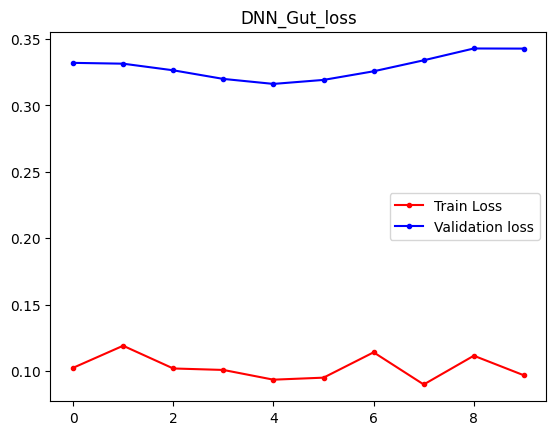

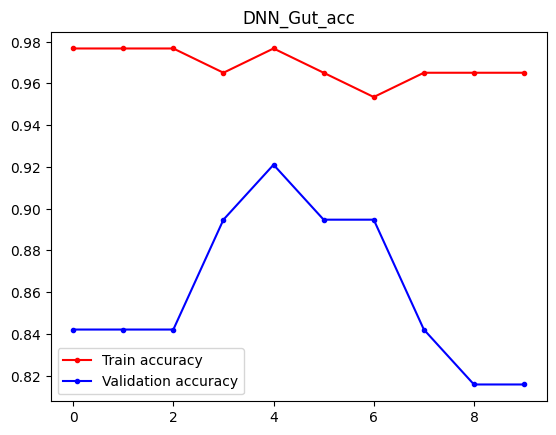

In [87]:
evaluate_model(model2, history2_2, X_test2, y_test2)

Here we will test tensorboard another usefull evaluation tool thats what for we needed tensorboard callback created earlier 

In [78]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [99]:

%tensorboard --logdir logdir --port=6007

Reusing TensorBoard on port 6007 (pid 6872), started 2:18:58 ago. (Use '!kill 6872' to kill it.)

In [84]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


Known TensorBoard instances:
  - port 6007: logdir logdir (started 0:00:14 ago; pid 10984)
  - port 6006: logdir tensorboard_log (started 1:11:50 ago; pid 26536)
  - port 6006: logdir tensorboard_logs/2024_04_14-12 (started 1:08:50 ago; pid 34192)
  - port 6006: logdir logs/fit (started 1:36:03 ago; pid 34956)
  - port 6006: logdir logdir (started 1:10:25 ago; pid 36808)
  - port 6006: logdir tensorboard_logs (started 1:27:25 ago; pid 37008)
  - port 6006: logdir logs (started 1:28:17 ago; pid 38296)
  - port 6006: logdir logdir (started 0:54:29 ago; pid 39888)
  - port 6006: logdir log_dir (started 1:09:32 ago; pid 43060)
  - port 6006: logdir tensorboard_logs\20240414-124757 (started 1:04:06 ago; pid 45080)
